# Opioid Data
HW #2 Part 2 - Timeseries.  
Use many rows per patient from about 30 consecutive days.

## Preprocessing
Patient files are in one of two directories: R or NR.  
Each patient is represented by one CSV file.  
Each row of each CSV contains readings from one day.    
Here, we load each patient average across all days.   

In [1]:
from os import listdir
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import FeatureAgglomeration
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [2]:
pathR='data/ChunkedData_R/'
pathN='data/ChunkedData_NR/'
filesR = listdir(pathR)
filesN = listdir(pathN)
print(len(filesR)," files of type R")
print(len(filesN)," files of type N")
CLASS_SEPARATOR=13  # data[:13] vs data[13:]
WITH_VARIANCE_COLUMNS=True   # Use mean and variance per patient

14  files of type R
26  files of type N


In [3]:
# Read one CSV file. 
# Create a Pandas data frame.
# Drop the date column.
def file_mean (filepath):
    mydata = pd.read_csv(filepath)
    # Drop the date column.
    mydata = mydata.drop('Date',axis=1) 
    mcols = [name+'M' for name in mydata.columns]
    vcols = [name+'V' for name in mydata.columns]
    # Transpose column of mean values into a row.
    mymean = mydata.mean(axis=0).to_frame().T
    mymean.columns=mcols
    myvar = mydata.var(axis=0).to_frame().T
    myvar.columns=vcols
    return mymean,myvar

In [4]:
# Read directory of CSV files (R or NR). 
# Create one dataframe representing all files.
# Retain only one row per file = column averages.
def mean_per_file (directory,variance):
    files = listdir(directory)
    means = pd.DataFrame()
    for fp in files:
        dfp = directory+fp
        m,v = file_mean(dfp)
        m_v = pd.concat([m,v],axis=1)
        # Let Pandas number the rows sequentially.
        means = means.append(m_v,ignore_index=True)
    return means

In [5]:
meansR = mean_per_file(pathR,WITH_VARIANCE_COLUMNS)
meansR.describe()

,Morning_Question1M,Morning_Question2M,Morning_Question3M,Morning_Question4M,Morning_Question5M,Morning_Question6M,Afternoon_Question1M,Afternoon_Question2M,Afternoon_Question3M,Afternoon_Question4M,...,HR_meanV,HR_varV,HR_stdV,HR_skV,HR_kuV,Stress_meanV,Stress_varV,Stress_stdV,Stress_skV,Stress_kuV
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,2.771630,2.704766,3.684239,3.427975,2.393328,4.368998,3.686286,3.513472,2.736801,2.429426,...,34.372227,7795.079795,11.157802,0.211735,5.429303,130.564141,44286.087904,26.996662,0.445166,4.972088
std,1.339235,1.115521,1.206275,1.113369,0.893719,0.702195,1.221645,1.272435,1.147496,1.152266,...,25.631061,6375.381932,7.541068,0.213722,15.155830,82.871183,32614.389556,17.636954,0.325842,7.017045
min,1.000000,1.000000,1.000000,1.310345,1.517241,2.517241,1.000000,1.000000,1.000000,1.000000,...,8.742554,475.972601,1.425214,0.088300,0.204720,23.255380,12172.325488,9.331900,0.171789,0.642274
25%,1.956981,2.169643,3.302760,2.539577,1.972222,3.958128,2.908279,3.087662,1.551724,1.310345,...,17.234079,2037.723414,4.796564,0.121842,1.153600,71.312686,19172.381140,11.966783,0.261594,1.930655
50%,2.857759,2.393939,3.928480,3.847222,2.064394,4.403941,4.000000,3.772727,3.000000,2.214286,...,28.815820,7134.524178,12.062591,0.145488,1.624992,108.744908,33891.228153,25.255710,0.356057,2.724132
75%,3.435737,3.758621,4.419540,4.000000,2.423701,4.979167,4.713362,4.326149,3.772727,3.607955,...,38.449174,12748.013510,14.740333,0.215462,1.865365,158.278579,57409.457138,34.926301,0.467254,4.274385
max,5.000000,4.448276,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.035714,3.962963,...,102.064435,19352.257310,26.517144,0.930167,58.042538,314.010811,127562.172736,75.155578,1.454651,28.194354


In [6]:
meansN = mean_per_file(pathN,WITH_VARIANCE_COLUMNS)
meansN.describe()

,Morning_Question1M,Morning_Question2M,Morning_Question3M,Morning_Question4M,Morning_Question5M,Morning_Question6M,Afternoon_Question1M,Afternoon_Question2M,Afternoon_Question3M,Afternoon_Question4M,...,HR_meanV,HR_varV,HR_stdV,HR_skV,HR_kuV,Stress_meanV,Stress_varV,Stress_stdV,Stress_skV,Stress_kuV
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,2.982123,2.888846,4.235503,3.537182,2.198923,4.308005,4.279549,4.207332,3.086296,2.498761,...,35.401291,7463.312024,8.824132,0.285265,3.720685,130.966486,35508.104155,21.904656,0.535252,7.537642
std,1.295793,1.195432,0.749181,1.094154,1.225848,0.605677,0.759156,0.893941,1.475356,1.406318,...,22.922819,8416.222926,7.059484,0.258522,5.251969,94.425443,24507.102981,10.768108,0.375209,9.427802
min,1.000000,1.000000,2.241379,1.000000,1.000000,3.375000,2.655172,1.965517,1.000000,1.000000,...,3.212049,409.131542,0.840543,0.041430,0.217647,5.562469,3236.258881,4.705337,0.093928,0.240426
25%,1.648348,2.206897,4.000000,2.969109,1.086207,3.758621,3.612069,3.810345,1.140445,1.000000,...,18.004090,1061.647756,3.483471,0.122933,0.701214,56.731256,18855.312756,11.732004,0.251583,2.534023
50%,3.465517,3.155093,4.162835,3.885776,2.035714,4.275223,4.431034,4.362069,3.716236,2.379310,...,29.436331,3830.952644,7.010226,0.193542,1.443744,115.407096,30205.448898,23.339835,0.411815,4.039925
75%,3.982759,3.913793,4.965517,4.000000,3.017241,4.913793,5.000000,5.000000,4.000000,3.721675,...,47.896306,9733.137191,11.406218,0.353734,4.772151,175.495580,50924.747490,30.802759,0.672522,8.697156
max,4.931034,4.555556,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,78.579913,27765.514599,24.774942,1.031303,22.879166,336.939869,94124.034377,40.365547,1.407404,39.377742


In [7]:
# Combine all data (R and NR) into one data frame.
# Label R = positive = 1 = blue.
# Label NR = negative = 0 = red.
def make_labels(positives,negatives):
    rows = positives.shape[0]
    labelsP = pd.DataFrame(np.ones(rows,dtype=np.int8))  # one = blue
    rows = negatives.shape[0]
    labelsN = pd.DataFrame(np.zeros(rows,dtype=np.int8))  # zero = red
    labelsAll = pd.concat((labelsP,labelsN),ignore_index=True)
    return labelsAll

In [8]:
# If we had all the data and their labels in one place, we could do this:
#allData.groupby('R_NR').mean().T
# Instead, we have unlabeled data in meansAll orgranized by position (R then NR)
meansAll = pd.concat((meansR,meansN),ignore_index=True)
print("(rows,columns)=",meansAll.shape)
labels_df = make_labels(meansR,meansN)
#print(labels_df.T)

(rows,columns)= (40, 518)


## Scaling and covariance
Normalize by subtracting the column mean from every column value.  
Since columns have widely different numerical ranges,   
also normalize by making each column have unit variance.  
Note: without normalization, the covariance plot would be all black except for the few features with large absolute values.

In [9]:
# Standardize features by shifting the mean to zero and scaling to unit variance.
# Subtract the mean and divide by the std.dev: z = (x - u) / s
def scale_features(X):
    s = StandardScaler()
    z = s.fit_transform(X)
    return z
scaledMeans = scale_features(meansAll)
column_names = meansAll.columns

In [10]:
print("Column Names:")
print(column_names)
print("Scaled Means & Variances:")
scaledMeans

Column Names:
Index(['Morning_Question1M', 'Morning_Question2M', 'Morning_Question3M',
       'Morning_Question4M', 'Morning_Question5M', 'Morning_Question6M',
       'Afternoon_Question1M', 'Afternoon_Question2M', 'Afternoon_Question3M',
       'Afternoon_Question4M',
       ...
       'HR_meanV', 'HR_varV', 'HR_stdV', 'HR_skV', 'HR_kuV', 'Stress_meanV',
       'Stress_varV', 'Stress_stdV', 'Stress_skV', 'Stress_kuV'],
      dtype='object', length=518)
Scaled Means & Variances:


array([[-0.74, -0.57, -0.69, ..., -0.49, -0.24, -0.55],
       [ 0.37, -0.06, -0.12, ..., -0.21, -0.64, -0.27],
       [-1.41,  1.24,  1.01, ..., -1.07, -0.94, -0.55],
       ...,
       [ 0.04, -0.07,  0.84, ...,  0.47, -0.43, -0.35],
       [ 0.1 ,  1.52,  1.01, ...,  0.93,  0.33, -0.45],
       [ 0.85,  0.32,  0.19, ..., -1.05, -1.02, -0.34]])

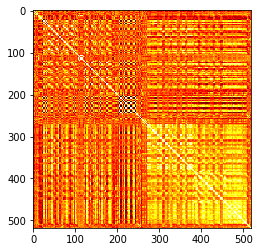

In [11]:
def plot_covariance(X):
    cv=X.T.dot(X)/len(X)
    plt.imshow(cv, cmap='hot', interpolation='nearest')
    plt.show()
plot_covariance(scaledMeans)

In [12]:
pathR = None
pathN = None
filesR = None
filesN = None
meansR = None
meansN = None
meansAll = None